In [47]:
from gensim import corpora, models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from nltk.stem.snowball import EnglishStemmer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score
import time
import pandas as pd
import numpy as np
from nltk.stem import WordNetLemmatizer
import enchant
import re
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer
import enchant
import re
from sklearn.neighbors import KNeighborsClassifier
from nltk.probability import FreqDist
from sklearn.svm import SVC
import fasttext

In [3]:
random_state=0
lemmatizer = WordNetLemmatizer()
eng_dic = enchant.Dict("en_US")

# Step 1

## Data loading

In [4]:
df = pd.read_json(path_or_buf='amazon_step1.json',orient='records',lines=True)

In [5]:
df.head()

,asin,category,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,B000J4HXUC,Sports_and_Outdoors,"[1, 1]",5,It's a .50 Caliber Ammo Can. That largely sums...,"01 5, 2014",A3QRW0UJPKIAX7,Grant Fritchey,Clean and Exactly as Advertised,1388880000
1,0983393214,Books,"[0, 0]",5,This was a very good book. It kept me excited ...,"06 23, 2013",A2SEIOM4H06WTH,TJ,Great read!,1371945600
2,B003G4FVMY,Grocery_and_Gourmet_Food,"[0, 0]",5,"If you love coconut the way I do, you can't go...","05 19, 2013",A3GDEXMU9587JX,"K. Parsley ""kindlekat""","If you love coconut, get this coffee",1368921600
3,B00F9VRNF0,Cell_Phones_and_Accessories,"[0, 0]",5,I recently switched from the Galaxy S3 to the ...,"04 25, 2014",ASP3J2NEHDN4E,ChriS,Superior Protection!!!,1398384000
4,B00D5OZQUC,Amazon_Instant_Video,"[0, 0]",5,"Good show,looks like the gap from season 2 to ...","11 4, 2013",A1EDBI6TBKP9CO,Grants Book Trade,"Love the show, thanks for putting Season 3 on ...",1383523200


In [6]:
# TODO remove sampling
# Sampling to minimze computing cost
df = df.sample(5000,random_state=random_state)
df.head()

,asin,category,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
32311,B00109US84,Clothing_Shoes_and_Jewelry,"[0, 0]",5,I purchased this dress for my oldest daughter ...,"11 17, 2011",AFT0MSD3TM9CK,J. Leonard,"Great Dress, Great Price and Great Color",1321488000
90348,B000VJ7PC6,Beauty,"[0, 0]",5,Smelled this at Ulta and it is delicious. I pi...,"02 15, 2013",A1EMYTJKY3NA9F,oldfriends,Fuel For Life Homme,1360886400
19274,B001BOKGDU,Home_and_Kitchen,"[0, 0]",1,I never could make this coffeemaker produce de...,"06 6, 2013",ABXCC3A0JFQ8Q,carefulshopper,Made terrible coffee...,1370476800
62697,B005BYZAWI,Tools_and_Home_Improvement,"[0, 0]",4,"Not sure how long they last yet, but they seem...","11 21, 2013",A32UFI1Y91JUU1,"Scott C Jones ""HenryJonesJr""",Great buy.,1384992000
39787,B000FJYSHW,Patio_Lawn_and_Garden,"[0, 0]",5,I got one of these to replace a &#34;plastic&#...,"07 19, 2013",A2IX2PCXS5O2FK,Mike In San Diego,dihydrogen monoxide diverter!,1374192000


## Pre-processing

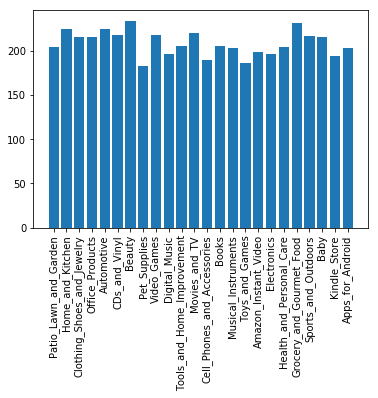

In [7]:
#Visualize if we have all categories
categories = set(df['category'])
category_occurence = []
categories_array = []
for category in categories:
    category_occurence.append(len(df[df['category']==category]))
    categories_array.append(category)

x = np.arange(1,25)
y = category_occurence

plt.bar(x, category_occurence)
plt.xticks(x, categories_array,rotation='vertical')
plt.show()

In [8]:
#Given a sentence return array of nouns only
def extract_set_nouns(sentence):
    data = pos_tag(word_tokenize(sentence), tagset='universal');
    
    worded_sentence = [i[0].lower() for i in data if (i[1] == 'NOUN') ]
    
    new_sentence = ""
    for word in set(worded_sentence):
        new_sentence += " " + word
    return (new_sentence)

#Given word return if it contains number or not
def hasNumbers(inputString):
    return bool(re.search(r'\d', inputString))


In [9]:
#Extract nouns only and make lowercase
reviewText_noun = [extract_set_nouns(sentence).lower() for sentence in df['reviewText']]

reviewText_noun_no_special_character = []
reviewText_noun_no_special_character_no_english = []

#Remove special characters
for item in reviewText_noun:
    reviewText_noun_no_special_character.append(item.replace('\r',' ').replace('/n',' ').replace('.',' ').replace(',',' ').replace('(',' ')\
                                             .replace(')',' ').replace("'s",' ').replace('"',' ')\
                                             .replace('!',' ').replace('?',' ').replace("'",' ')\
                                             .replace('>',' ').replace('$',' ')\
                                             .replace('-',' ').replace(';',' ')\
                                             .replace(':',' ').replace('/',' ').replace('#',' '))


#Remove non english words and numbers and length less than 2 then lemmatize
reviewText_noun_no_special_character_no_english = [[lemmatizer.lemmatize(token) for token in comment.split() if ((eng_dic.check(token)) and (not hasNumbers(token)) and (len(token)>1)) ] 
                    for comment in reviewText_noun_no_special_character]
    
#Return to sentence format
seperated_comments = [' '.join(sentence) for sentence in reviewText_noun_no_special_character_no_english]

#Get only nouns once again. Some special characters and other factors messed the function in the first place
almost_ready_comments = [extract_set_nouns(sentence) for sentence in seperated_comments]


In [ ]:
#Get most frequent words to add to stoplist if not found to be relevant
words = []
for token in almost_ready_comments:
    for word in token.split():
        words.append(word)

fdist = FreqDist(words)
top_n = fdist.most_common(100)

for word in top_n:
    print (word,"\n")

Many of the frequent terms are not useful. Some examples:<br/>
lot, end, set, time, year, month, day, great (even though it's a noun), price, one, month, thing, it, issue, use, the, others, minute, nothing, week, this, hour, stuff, feel, my, mine, name, so, cost, problem, 

In [ ]:
#Manually updated the stopwords to add some that were not relevant
#Remove stopwords that we found to be not relevant in the previous part
stopword_file=open('stopwords_list_step1.txt')
stoplist=stopword_file.read().split()

#Still need to remove stopwords
ready_comments = [" ".join([token for token in comment.split() if (token not in stoplist) ]) for comment in almost_ready_comments]


In [12]:
#We will change the reviewText for all data. It doesn't matter if it's test or train
df['reviewText']=ready_comments
print (len(ready_comments))

5000


In [13]:
#Remove data with no content in reviewText
df = df[df['reviewText'].map(len) > 1]
print (len(df['reviewText']))

4992


## Vectorizing the review text

In [14]:

# TODO better stoplist
# Current list :default english stopwords list from http://www.ranks.nl/stopwords
stopword_file=open('stopwords_list_step1.txt')
stoplist=stopword_file.read().split()
# configure CountVectorizer to include nltk-stemmer
stemmer = EnglishStemmer()
analyzer = CountVectorizer().build_analyzer()

def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

# create vectorizer instance including the stop list and stemizer. 
# TODO modify max_df, min_df ?
stem_vectorizer = CountVectorizer(analyzer=stemmed_words,stop_words=stoplist,max_df=0.4,min_df=2,)

# fit vectorizer, carry out vectorization and display results
stem_vectorizer.fit(df['reviewText'])
documents_vec = stem_vectorizer.transform(df['reviewText'])
print(documents_vec) # sparse matrix representation
#print (stem_vectorizer)

  (0, 146)	1
  (0, 218)	1
  (0, 312)	1
  (0, 349)	1
  (0, 378)	1
  (0, 733)	1
  (0, 755)	1
  (0, 945)	1
  (0, 971)	1
  (0, 1152)	1
  (0, 1272)	1
  (0, 1314)	1
  (0, 1430)	1
  (0, 1556)	1
  (0, 1724)	1
  (0, 1976)	1
  (0, 2038)	1
  (0, 2122)	1
  (0, 2406)	1
  (0, 2597)	1
  (0, 2607)	1
  (0, 2697)	1
  (0, 2739)	1
  (0, 2804)	1
  (0, 2807)	1
  :	:
  (4991, 2575)	1
  (4991, 2668)	1
  (4991, 2731)	1
  (4991, 2739)	1
  (4991, 2752)	1
  (4991, 2819)	1
  (4991, 2919)	1
  (4991, 2932)	1
  (4991, 2989)	1
  (4991, 3079)	1
  (4991, 3140)	1
  (4991, 3183)	1
  (4991, 3249)	1
  (4991, 3326)	1
  (4991, 3328)	1
  (4991, 3333)	1
  (4991, 3559)	1
  (4991, 3647)	1
  (4991, 3688)	1
  (4991, 3725)	1
  (4991, 3741)	1
  (4991, 3779)	1
  (4991, 3805)	1
  (4991, 3850)	1
  (4991, 4022)	1


## Category Prediction 

#### Pre-Processing

X is the review word vector. y are the corresponding categories.

The data is Min/max scaled into [0;1]. It isn't standartize because we want positive values. One could try a normalization (l1 or l2 for example)

We split the data into a train and test set. 

tf/idf is not relevant since words that appear often might suggest a category (such as 'book')

In [15]:
X=documents_vec.toarray()
y=df['category']
categories=np.unique(y)

In [16]:
# Scaling the data
X_scaled=[]
for doc in X:
    min_max_scaler = preprocessing.MinMaxScaler()
    X_scaled.append(np.ravel(min_max_scaler.fit_transform(doc.reshape(-1, 1))))

/Users/fayezmourad/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=random_state)

In [18]:
# Numpy arrays
X_train=np.array(X_train)
X_test=np.array(X_test)
y_train=np.array(y_train)
y_test=np.array(y_test)
print (X_train)

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


#### dummy classifier

Baseline model: Assign the categories randomly.

In [19]:
start = time.time()

y_pred=[]

for i in range(X_test.shape[0]):
    y_pred.append(categories[np.random.randint(0,24)])
print("accuracy:",accuracy_score(y_test,y_pred))

end=time.time()
print("Execution time : {} seconds".format(end-start))

accuracy: 0.047047047047
Execution time : 0.007409811019897461 seconds


#### Cosine similarity

For each category  we regroup the documents belonging to this category together. Then for each element we want to predict, we check how similar it is compared to each group (cosine similarity). The most similar group gives the category to the element.

In [20]:
import warnings
warnings.filterwarnings('ignore')

start= time.time()
# TODO: Optimizazion : precalculate the ref_documents
y_pred=[]

# For each element to predict
for idx,x in enumerate(X_test):
    if idx % 100 == 0:
        print(idx)
    
    best_category=""
    best_sim=0
    # for each category to check
    for cat in categories:
        # documents representing the category
        ref_docs=X_train[[y_train==cat][0]]
        # similarity between each reference document and the element
        sim=cosine_similarity(ref_docs,x)
        # If overall similarity better than best, change best
        if(np.sum(sim)/len(ref_docs)>best_sim):
            best_sim=np.sum(sim)/len(ref_docs)
            best_category=cat
    # Assign best category
    y_pred.append(best_category)
print("accuracy:",accuracy_score(y_test,y_pred))

end=time.time()
print("Execution time : {} seconds".format(end-start))

0
100
200
300
400
500
600
700
800
900
accuracy: 0.45045045045
Execution time : 287.5315330028534 seconds


#### Decision tree

Try various maximum depths for a classic decision tree classifier

1
11
21
31
41
51
61
71
81
91
101
111
121
131
141
151
161
171
181
191
201
211
221
231
241
251
261
271
281
291
301
311
321
331
341
351
361
371
381
391
401
411
421
431
441
451
461
471
481
491


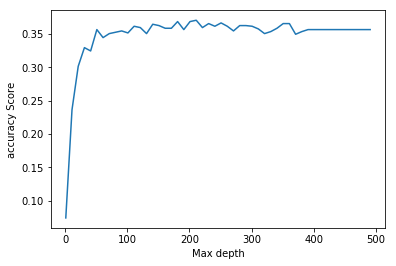

best depth= 211 with accuracy score: 0.37037037037
Execution time : 385.6638617515564 seconds


In [21]:
start=time.time()

accuracy=[]
depths=range(1,500,10)
# Check various max_depth
for max_depth in depths:
    print(max_depth)
    # fit regression model with different tree depths
    reg_tree = DecisionTreeClassifier(max_depth=max_depth, random_state=random_state,)
    reg_tree.fit(X_train, y_train)
    # predict a synthetic test data
    y_pred = reg_tree.predict(X_test)
    accuracy.append(accuracy_score(y_test,y_pred))

# Plot
plt.plot(depths,accuracy)
plt.ylabel("accuracy Score")
plt.xlabel("Max depth")
plt.show()
best_depth=depths[np.argmax(accuracy)]
print("best depth=",best_depth,"with accuracy score:", np.max(accuracy))

end=time.time()
print("Execution time : {} seconds".format(end-start))

#### K nearest neighbors

1
4
7
10
13
16
19
22
25
28
31
34
37
40
43
46
49


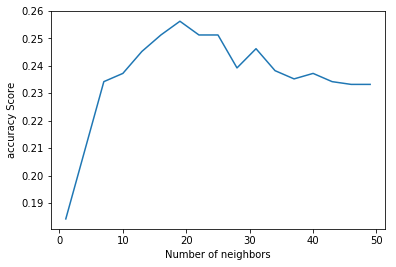

best number of neighbors= 19 with accuracy score: 0.256256256256
Execution time : 482.59851694107056 seconds


In [22]:
start=time.time()

accuracy=[]
num_neighbors=range(1,50,3)
# Check various number neighbors
for neighbors in num_neighbors:
    print(neighbors)
    # fit regression model with different number of neighbors
    knn = KNeighborsClassifier(n_neighbors=neighbors, weights='distance')
    knn.fit(X_train, y_train)
    # predict a synthetic test data
    y_pred = knn.predict(X_test)
    accuracy.append(accuracy_score(y_test,y_pred))

# Plot
plt.plot(num_neighbors,accuracy)
plt.ylabel("accuracy Score")
plt.xlabel("Number of neighbors")
plt.show()
best_num_neighbors=num_neighbors[np.argmax(accuracy)]
print("best number of neighbors=",best_num_neighbors,"with accuracy score:", np.max(accuracy))

end=time.time()
print("Execution time : {} seconds".format(end-start))

#### SVM

In [24]:
start=time.time()

accuracy=[]
C = np.logspace(-5,5,11)
# Check various C
for c_parameter in C:
    print(c_parameter)
    # fit SVC with rbf kernel
    scv_clf = SVC(C=c_parameter)
    scv_clf.fit(X_train, y_train)
    # predict a synthetic test data
    y_pred = scv_clf.predict(X_test)
    accuracy.append(accuracy_score(y_test,y_pred))

# Plot
plt.plot(c_parameter,accuracy)
plt.ylabel("accuracy Score")
plt.xlabel("C values")
plt.show()

end=time.time()
print("Execution time : {} seconds".format(end-start))

1e-05
0.0001
0.001
0.01
0.1
1.0
10.0
100.0
1000.0
10000.0
100000.0


ValueError: x and y must have same first dimension, but have shapes (1,) and (11,)

In [26]:
best_C= C[np.argmax(accuracy)]
print("best C=",best_C,"with accuracy score:", np.max(accuracy))

best C= 1000.0 with accuracy score: 0.466466466466


## We should use Cross validation no ?

#### Fast text analysis (to be done later)

#### Is giving wrong results will look at it later

In [76]:
#Reload the data without any preprocessing to use fasttext
#The model with preprocessed data didn't give good results
df = pd.read_json(path_or_buf='amazon_step1.json',orient='records',lines=True)
df = df.sample(50000,random_state=random_state)
df.head()

,asin,category,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
32311,B00109US84,Clothing_Shoes_and_Jewelry,"[0, 0]",5,I purchased this dress for my oldest daughter ...,"11 17, 2011",AFT0MSD3TM9CK,J. Leonard,"Great Dress, Great Price and Great Color",1321488000
90348,B000VJ7PC6,Beauty,"[0, 0]",5,Smelled this at Ulta and it is delicious. I pi...,"02 15, 2013",A1EMYTJKY3NA9F,oldfriends,Fuel For Life Homme,1360886400
19274,B001BOKGDU,Home_and_Kitchen,"[0, 0]",1,I never could make this coffeemaker produce de...,"06 6, 2013",ABXCC3A0JFQ8Q,carefulshopper,Made terrible coffee...,1370476800
62697,B005BYZAWI,Tools_and_Home_Improvement,"[0, 0]",4,"Not sure how long they last yet, but they seem...","11 21, 2013",A32UFI1Y91JUU1,"Scott C Jones ""HenryJonesJr""",Great buy.,1384992000
39787,B000FJYSHW,Patio_Lawn_and_Garden,"[0, 0]",5,I got one of these to replace a &#34;plastic&#...,"07 19, 2013",A2IX2PCXS5O2FK,Mike In San Diego,dihydrogen monoxide diverter!,1374192000


In [73]:
#split df into train and test
df['category'] = '__label__' + df['category'].astype(str)
msk = np.random.rand(len(df)) < 0.8
df_train = df[msk]
df_test = df[~msk]

In [74]:
#Load training model with labels
df_train.to_csv("train.csv", columns=['category','reviewText'],index=False,header=False)
#Load test model without labels
df_test.to_csv("test.csv",columns=['category','reviewText'],index=False,header=False)

In [75]:
classifier = fasttext.supervised('train.csv', 'model')

In [95]:
np_df = df.as_matrix()

In [98]:
print (np_df[2][1])
text = np_df[2][4]
print (text ,"\n")
label = classifier.predict(text)
print (label)

Home_and_Kitchen
I never could make this coffeemaker produce decent coffee, and I have been using coffeemakers successfully for years (my last one, another brand, just finally burned out.)  So I sent the Black and Decker back with my regrets... 

[['Apps_for_Android,I'], ['Patio_Lawn_and_Garden,'], ['Beauty,"Smelled'], ['Beauty,"Smelled'], ['Beauty,"Smelled'], ['Beauty,"Smelled'], ['Beauty,"Smelled'], ['Patio_Lawn_and_Garden,'], ['Beauty,"Smelled'], ['Beauty,"Smelled'], ['Beauty,"Smelled'], ['Beauty,"Smelled'], ['Beauty,"Smelled'], ['Patio_Lawn_and_Garden,'], ['Beauty,"Smelled'], ['Beauty,"Smelled'], ['Beauty,"Smelled'], ['Beauty,"Smelled'], ['Patio_Lawn_and_Garden,'], ['Beauty,"Smelled'], ['Beauty,"Smelled'], ['Patio_Lawn_and_Garden,'], ['Beauty,"Smelled'], ['Patio_Lawn_and_Garden,'], ['Beauty,"Smelled'], ['Beauty,"Smelled'], ['Beauty,"Smelled'], ['Beauty,"Smelled'], ['Beauty,"Smelled'], ['Beauty,"Smelled'], ['Beauty,"Smelled'], ['Beauty,"Smelled'], ['Beauty,"Smelled'], ['Beauty,"Smel